In [1]:
import numpy as np
import nltk
import keras
import gensim

/Users/jonathanbleiberg/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from nltk.corpus import brown
import gensim.downloader as gdl

pretrained_glove = gdl.load('glove-wiki-gigaword-100')

In [3]:
# extract all trigrams that have a vector representation
def get_trigrams(words, model, doc_id):
    trigrams = [None for _ in range(len(words) - 2)]
    for i in range(len(words) - 2):
        # loop through all trigrams in text
        curr_trigram = (words[i], words[i+1], words[i+2], doc_id)
        # include trigram if all words have a vector representation
        if curr_trigram[0] in model and curr_trigram[1] in model and curr_trigram[2] in model:
            trigrams[i] = curr_trigram
    return [tri for tri in trigrams if tri is not None]

# perturb the second word of each trigram
def get_perturbations(trigrams, model):
    perturbed_trigrams = [None for _ in range(len(trigrams))]
    # index of word choosen (from 1st-3rd most similar word)
    rand_idxs = np.random.randint(0,2,len(trigrams))
    for idx, tri in enumerate(trigrams):
        if idx % 1000 == 0:
            print(idx)
        # get 1st-3rd most similar word to middle word of trigram
        perturbed_trigrams[idx] = model.most_similar(tri[1], topn=3)[rand_idxs[idx]][0]
    return perturbed_trigrams

# create trigram and perturbed word dataset
def create_dataset(words, model, doc_id):
    trigrams = get_trigrams(words, model, doc_id)
    perturbed_trigrams = get_perturbations(trigrams, model)
    return trigrams, perturbed_trigrams

In [4]:
np.random.seed(42)
full_tris, full_perturbed = [],[]
for idx, cat in enumerate(brown.categories()):
    print(cat)
    %time trigrams, perturbed = create_dataset(brown.words(categories=cat)[:5000], pretrained_glove, idx)
    full_tris += trigrams
    full_perturbed += perturbed
        
    

adventure
0
1000
2000
3000
CPU times: user 2min 57s, sys: 2.33 s, total: 2min 59s
Wall time: 1min 50s
belles_lettres
0
1000
2000
3000
CPU times: user 3min 14s, sys: 2.63 s, total: 3min 16s
Wall time: 1min 58s
editorial
0
1000
2000
3000
CPU times: user 2min 43s, sys: 1.39 s, total: 2min 44s
Wall time: 1min 35s
fiction
0
1000
2000
3000
CPU times: user 3min, sys: 1.7 s, total: 3min 1s
Wall time: 1min 46s
government
0
1000
2000
3000
CPU times: user 2min 51s, sys: 876 ms, total: 2min 52s
Wall time: 1min 36s
hobbies
0
1000
2000
3000
CPU times: user 3min, sys: 1.12 s, total: 3min 1s
Wall time: 1min 41s
humor
0
1000
2000
3000
CPU times: user 3min 5s, sys: 1.93 s, total: 3min 7s
Wall time: 1min 51s
learned
0
1000
2000
3000
CPU times: user 3min 18s, sys: 1.54 s, total: 3min 19s
Wall time: 1min 54s
lore
0
1000
2000
3000
CPU times: user 3min 4s, sys: 1.24 s, total: 3min 5s
Wall time: 1min 45s
mystery
0
1000
2000
3000
CPU times: user 2min 47s, sys: 1.2 s, total: 2min 48s
Wall time: 1min 35s
news
0


In [5]:
# build the vocabulary and create dictionaries to convert between word and index
def build_vocab(trigrams, perturbed_trigrams):
    # extract all words in input and output
    words = [i for i, _, _, _ in trigrams] + [trigrams[-1][1]] + [trigrams[-1][2]]
    words += [i for i in perturbed_trigrams]
    # get unique words
    vocab = set(words)
    
    # create dicts to conver index
    word2idx = {word:idx for idx, word in enumerate(vocab)}
    idx2word = {idx:word for idx, word in enumerate(vocab)}
    return vocab, word2idx, idx2word

In [6]:
vocab, word2idx, idx2word = build_vocab(full_tris, full_perturbed)

In [7]:
# convert trigrams to concatenated vector representation
def trigrams_to_matrix(trigrams, model, vec_size):
    word_input_matrix = np.zeros((len(trigrams), vec_size * 3))
    for idx, tri in enumerate(trigrams):
        word_input_matrix[idx] = np.concatenate((model.get_vector(tri[0]),
                                                 model.get_vector(tri[1]), 
                                                 model.get_vector(tri[2])))
    return word_input_matrix
# convert perturbed words to array of integer labels
def perturbed_to_labels(perturbed, word2idx):
    return np.array([word2idx[w] for w in perturbed])

# extract document ids as np array
def doc_ids_to_vec(trigrams):
    return np.array([idx for _, _, _, idx in trigrams])


In [8]:
word_input_mat = trigrams_to_matrix(full_tris, pretrained_glove, 100)
labels = perturbed_to_labels(full_perturbed, word2idx)
doc_ids = doc_ids_to_vec(full_tris)

In [9]:
from sklearn.preprocessing import LabelBinarizer
# convert interger labels to one hot encoding
def convert_to_one_hot(labels, vocab_size):
    one_hot_encoder = LabelBinarizer()
    one_hot_encoder.fit(range(vocab_size))
    labels_one_hot = one_hot_encoder.transform(labels)
    return labels_one_hot

In [13]:
labels_one_hot = convert_to_one_hot(labels, len(vocab))

In [15]:
from keras.models import Model
from keras.layers import Embedding, Dense, Input

embedding_dim = 50  # dimension of document embedding
n_docs = len(brown.categories())  # number of docs in corpus
vec_dim = 100  # dimension of word embedding vectors
hidden_size = 128  # dimension of hidden layer
vocab_size = len(vocab) # number of words in vocab
batch_size = 64 



# input layer for document id
doc_input = Input(shape=(1,), name="doc_input", dtype='int32')
# input layer for concatenated word vectors
words_input = Input(shape=(vec_dim*3,), name="word1_input", dtype='float32')

# document embedding layer
x_1 = keras.layers.Flatten()(Embedding(input_dim=n_docs, output_dim=embedding_dim, name='embeddings')(doc_input))
# concatenate document andword embeddings
X = keras.layers.concatenate([x_1, words_input])
# pass through hidden layer
X = Dense(hidden_size, activation='relu')(X)
# output softmax probailities
output = Dense(vocab_size, activation='softmax')(X)

model = Model(inputs = [doc_input, words_input], outputs=[output])

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [17]:
# train for 20 epochs
model.fit([doc_ids, word_input_mat], [labels_one_hot], epochs=20, batch_size=batch_size)

Epoch 1/20
53020/53020 [==============================] - 109s 2ms/step - loss: 4.6540
Epoch 2/20
53020/53020 [==============================] - 105s 2ms/step - loss: 2.8160
Epoch 3/20
53020/53020 [==============================] - 105s 2ms/step - loss: 1.9627
Epoch 4/20
53020/53020 [==============================] - 108s 2ms/step - loss: 1.4433
Epoch 5/20
53020/53020 [==============================] - 107s 2ms/step - loss: 1.0961
Epoch 6/20
53020/53020 [==============================] - 110s 2ms/step - loss: 0.8581
Epoch 7/20
53020/53020 [==============================] - 106s 2ms/step - loss: 0.7043
Epoch 8/20
53020/53020 [==============================] - 105s 2ms/step - loss: 0.6123
Epoch 9/20
53020/53020 [==============================] - 106s 2ms/step - loss: 0.5561
Epoch 10/20
53020/53020 [==============================] - 112s 2ms/step - loss: 0.5160
Epoch 11/20
53020/53020 [==============================] - 111s 2ms/step - loss: 0.4830
Epoch 12/20
53020/53020 [================

In [18]:
model.save('brown_first_5000.h5')

In [19]:
embed = model.layers[1].get_weights()[0]

In [20]:
embed.shape

(15, 50)

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


scaler = StandardScaler()
standardized_embeddings = scaler.fit_transform(embed)

tsne_1 = TSNE(random_state=42, perplexity=2)
embeddings_2d_tsne = tsne_1.fit_transform(standardized_embeddings)

pca_1 = PCA(n_components=2)
embeddings_2d_pca = pca_1.fit_transform(standardized_embeddings)

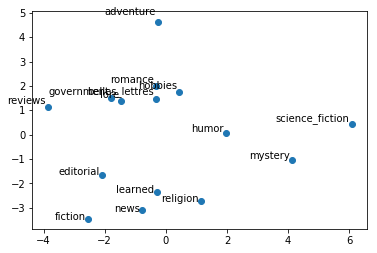

In [24]:
import matplotlib.pyplot as plt

plt.scatter(embeddings_2d_pca[:,0], embeddings_2d_pca[:,1])

for label, x, y in zip(brown.categories(), embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2, y),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

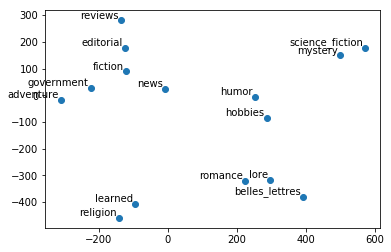

In [25]:
plt.scatter(embeddings_2d_tsne[:,0], embeddings_2d_tsne[:,1])

for label, x, y in zip(brown.categories(), embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2,0),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

In [27]:
from nltk.corpus import gutenberg
full_tris, full_perturbed = [],[]
for idx, f in enumerate(gutenberg.fileids()):
    print(f)
    %time trigrams, perturbed = create_dataset(gutenberg.words(fileids=f)[:5000], pretrained_glove, idx)
    full_tris += trigrams
    full_perturbed += perturbed

austen-emma.txt
0
1000
2000
3000
CPU times: user 3min, sys: 4.37 s, total: 3min 4s
Wall time: 1min 48s
austen-persuasion.txt
0
1000
2000
3000
CPU times: user 3min 16s, sys: 4.24 s, total: 3min 20s
Wall time: 1min 54s
austen-sense.txt
0
1000
2000
3000
4000
CPU times: user 3min 16s, sys: 4.45 s, total: 3min 20s
Wall time: 1min 55s
bible-kjv.txt
0
1000
2000
3000
CPU times: user 2min 46s, sys: 3.68 s, total: 2min 49s
Wall time: 1min 36s
blake-poems.txt
0
1000
2000
CPU times: user 1min 54s, sys: 2.64 s, total: 1min 57s
Wall time: 1min 8s
bryant-stories.txt
0
1000
2000
3000
CPU times: user 2min 27s, sys: 3.35 s, total: 2min 30s
Wall time: 1min 26s
burgess-busterbrown.txt
0
1000
2000
3000
CPU times: user 2min 23s, sys: 3.1 s, total: 2min 26s
Wall time: 1min 22s
carroll-alice.txt
0
1000
2000
3000
CPU times: user 2min 47s, sys: 3.59 s, total: 2min 51s
Wall time: 1min 36s
chesterton-ball.txt
0
1000
2000
3000
CPU times: user 2min 56s, sys: 3.77 s, total: 3min
Wall time: 1min 41s
chesterton-brown.

In [28]:
vocab, word2idx, idx2word = build_vocab(full_tris, full_perturbed)
word_input_mat = trigrams_to_matrix(full_tris, pretrained_glove, 100)
labels = perturbed_to_labels(full_perturbed, word2idx)
doc_ids = doc_ids_to_vec(full_tris)

In [29]:
labels_one_hot = convert_to_one_hot(labels, len(vocab))

In [30]:
embedding_dim = 50  # dimension of document embedding
n_docs = len(gutenberg.fileids())  # number of docs in corpus
vec_dim = 100  # dimension of word embedding vectors
hidden_size = 128  # dimension of hidden layer
vocab_size = len(vocab) # number of words in vocab
batch_size = 64 



# input layer for document id
doc_input = Input(shape=(1,), name="doc_input", dtype='int32')
# input layer for concatenated word vectors
words_input = Input(shape=(vec_dim*3,), name="word1_input", dtype='float32')

# document embedding layer
x_1 = keras.layers.Flatten()(Embedding(input_dim=n_docs, output_dim=embedding_dim, name='embeddings')(doc_input))
# concatenate document andword embeddings
X = keras.layers.concatenate([x_1, words_input])
# pass through hidden layer
X = Dense(hidden_size, activation='relu')(X)
# output softmax probailities
output = Dense(vocab_size, activation='softmax')(X)

model2 = Model(inputs = [doc_input, words_input], outputs=[output])

In [31]:
model2.compile(optimizer='adam', loss='categorical_crossentropy')

In [32]:
# train for 20 epochs
model2.fit([doc_ids, word_input_mat], [labels_one_hot], epochs=20, batch_size=batch_size)

Epoch 1/20
56175/56175 [==============================] - 94s 2ms/step - loss: 4.0727
Epoch 2/20
56175/56175 [==============================] - 93s 2ms/step - loss: 2.3766
Epoch 3/20
56175/56175 [==============================] - 94s 2ms/step - loss: 1.7308
Epoch 4/20
56175/56175 [==============================] - 93s 2ms/step - loss: 1.3252
Epoch 5/20
56175/56175 [==============================] - 93s 2ms/step - loss: 1.0458
Epoch 6/20
56175/56175 [==============================] - 94s 2ms/step - loss: 0.8490
Epoch 7/20
56175/56175 [==============================] - 94s 2ms/step - loss: 0.7177
Epoch 8/20
56175/56175 [==============================] - 93s 2ms/step - loss: 0.6431
Epoch 9/20
56175/56175 [==============================] - 94s 2ms/step - loss: 0.5910
Epoch 10/20
56175/56175 [==============================] - 92s 2ms/step - loss: 0.5554
Epoch 11/20
56175/56175 [==============================] - 93s 2ms/step - loss: 0.5258
Epoch 12/20
56175/56175 [===========================

In [33]:
model2.save('gutenberg_first_5000.h5')

In [34]:
embed = model2.layers[1].get_weights()[0]

In [35]:
embed.shape

(18, 50)

In [36]:
scaler = StandardScaler()
standardized_embeddings = scaler.fit_transform(embed)

tsne_1 = TSNE(random_state=42, perplexity=2)
embeddings_2d_tsne = tsne_1.fit_transform(standardized_embeddings)

pca_1 = PCA(n_components=2)
embeddings_2d_pca = pca_1.fit_transform(standardized_embeddings)

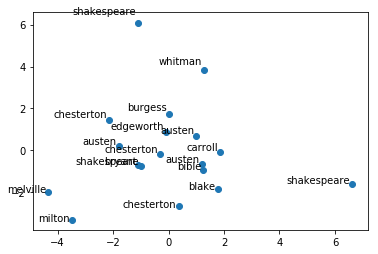

In [37]:
plt.scatter(embeddings_2d_pca[:,0], embeddings_2d_pca[:,1])

for label, x, y in zip([f.split('-')[0] for f in gutenberg.fileids()], embeddings_2d_pca[:, 0], embeddings_2d_pca[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2, y),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

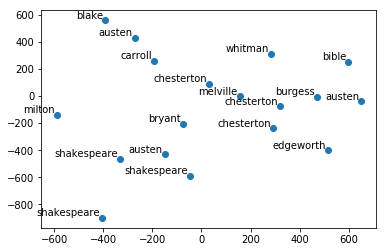

In [38]:
plt.scatter(embeddings_2d_tsne[:,0], embeddings_2d_tsne[:,1])

for label, x, y in zip([f.split('-')[0] for f in gutenberg.fileids()], embeddings_2d_tsne[:, 0], embeddings_2d_tsne[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-2,0),
        textcoords='offset points', ha='right', va='bottom')
plt.show()

In [39]:
from nltk.corpus import wordnet as wn

In [55]:
wn.synsets('why')

[Synset('why.n.01')]

In [50]:
'why' in wn.all_lemma_names()

True

In [ ]:
import random

# extract all trigrams that have a vector representation
def get_trigrams(words, model, doc_id):
    trigrams = [None for _ in range(len(words) - 2)]
    for i in range(len(words) - 2):
        # loop through all trigrams in text
        curr_trigram = (words[i], words[i+1], words[i+2], doc_id)
        # include trigram if all words have a vector representation
        if curr_trigram[0] in model and curr_trigram[1] in model and curr_trigram[2] in model:
            trigrams[i] = curr_trigram
    return [tri for tri in trigrams if tri is not None]

# perturb the second word of each trigram
def get_perturbations_by_synonym(trigrams, model):
    perturbed_trigrams = [None for _ in range(len(trigrams))]
    wn_lemmas = set(wn.all_lemma_names())
    n_syns = 0
    for idx, tri in enumerate(trigrams):
        if idx % 1000 == 0:
            print(idx)
            print(n_syns)
        # get 1st-3rd most similar word to middle word of trigram
        if tri[1] in wn_lemmas:
            syns = [w for w in random.choice(wn.synsets(tri[1])) if w != tri[1] and w in model]
            if syns != []:
                n_syns += 1
                perturbed_trigrams[idx] = random.choice(syns)
        else:
            perturbed_trigrams[idx] = model.most_similar(tri[1], topn=3)[rand_idxs[idx]][0]
    
    return perturbed_trigrams

# create trigram and perturbed word dataset
def create_dataset_v2(words, model, doc_id):
    trigrams = get_trigrams(words, model, doc_id)
    perturbed_trigrams = get_perturbations(trigrams, model)
    return trigrams, perturbed_trigrams

In [ ]:
full_tris, full_perturbed_v2 = [],[]
for idx, cat in enumerate(brown.categories()):
    print(cat)
    %time trigrams, perturbed = create_dataset(brown.words(categories=cat)[:5000], pretrained_glove, idx)
    full_tris += trigrams
    full_perturbed += perturbed